In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.ldamodel import LdaModel
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/marathi-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/marathi-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
test_data = []
file = open("../dataset/marathi-dataset/marathi-test-data.txt", "r", encoding="utf")
for row in file:
    if row == "text":
        continue
    test_data.append(row)
file.close()
test_data  = test_data[1:]
len(test_data)

1788

In [5]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
test_data = [clean_text(x) for x in test_data]
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(test_data))

41997
41997
3780
3780
1788


In [6]:
le, y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
corpus = []
for text in x_train:
    corpus.append(text)
print(len(corpus))
for text in x_val:
    corpus.append(text)
print(len(corpus))

41997
45777


In [10]:
tokenizer, x_train_tokenzied, x_val_tokenzied, x_test_tokenzied = tokenize_text(corpus, 
                                                                                x_train, 
                                                                                x_val, 
                                                                                test_data)

In [11]:
x_train_padded, x_val_padded, x_test_padded = pad_text(x_train_tokenzied, 
                                                       x_val_tokenzied, 
                                                       x_test_tokenzied,
                                                       pad_len, 
                                                       padding_type, 
                                                       truncating_type)

In [14]:
dump(tokenizer, "../tokenizers/DL-clean-text-tokenizer-100.pk1")

['../tokenizers/DL-clean-text-tokenizer-100.pk1']

In [12]:
print(x_train_padded.shape)
print(x_val_padded.shape)
print(x_test_padded.shape)

(41997, 100)
(3780, 100)
(1788, 100)


In [13]:
vocab = tokenizer.word_index
len(vocab.keys())

55100

# Domain Specific Fasttext Embeddings

In [15]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.complete.ft.skipgram.new.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

54625
Total time taken:  4.813431066


(55101, 300)

In [16]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  55101
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# LDA Topic-document matrix

In [17]:
LDA_model = LdaModel.load("/home/eastwind/word-embeddings/LDA/Normal/TechDofication.LDA.normal.raw.t12")

In [18]:
start = process_time()
X_train_LDA =prepare_LDA_input(training_data.text.values.tolist(), LDA_model)
X_val_LDA =prepare_LDA_input(val_data.text.values.tolist(), LDA_model)
X_test_LDA =prepare_LDA_input(test_data, LDA_model)
end = process_time()
print("Total time taken: ", end-start)
print(X_train_LDA.shape)
print(X_val_LDA.shape)
print(X_test_LDA.shape)

Total time taken:  18.419260207999997
(41997, 12)
(3780, 12)
(1788, 12)


In [19]:
input_len2 = X_train_LDA.shape[1]
print("Input dimension 2: ", input_len2)

Input dimension 2:  12


# Multi-channel BiLSTM-CNN Architecture with Attention

In [20]:
class TopicAttention(Layer):
    
    def __init__(self, **kwargs):
        super(TopicAttention, self).__init__(**kwargs)
       
    def build(self, attention_input):
        # Attention model weights
        self.W = self.add_weight(shape=(attention_input[-1], 1),
                                  initializer='normal',
                                  trainable=True,
                                  name='attention_weights')
        # Attention model bias
        self.b = self.add_weight(shape=(1, 1),
                                 initializer='normal',
                                 trainable=True,
                                 name='attention_bias')
        super(TopicAttention, self).build(attention_input)
       
        
    def call(self, attention_input):
        et = K.squeeze(K.tanh(K.dot(attention_input, self.W) + self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        at = attention_input * at
        return at
    
    
    def compute_output_shape(self, attention_input):
        return (attention_input[0], attention_input[-1])
    
    
    def get_config(self):
        return super(TopicAttention, self).get_config()

In [21]:
class AttentionLayer(Layer):
    
    def __init__(self, embedding_dim, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.W_in = Dense(self.embedding_dim)
        self.V = Dense(1)
    
        
    def call(self, attention_input):
        lstm_output, cnn_output = attention_input
        score = self.V(K.tanh(self.W_in(lstm_output)))
        attention_weights = K.softmax(score * cnn_output, axis=1)
        context_vector = tf.reduce_sum(lstm_output * attention_weights, axis=1)
        return context_vector
       
        
    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [22]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)

# Embeddings to BiLSTM:
Lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(Embedding_layer1)

# Embeddings to CNN:
Conv1 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(Embedding_layer1)
Dropout1 = Dropout(0.3)(Conv1)
Conv2 = Conv1D(filters=256, kernel_size=4, activation='relu', padding='same')(Embedding_layer1)
Dropout2 = Dropout(0.3)(Conv2)
Conv3 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(Embedding_layer1)
Dropout3 = Dropout(0.3)(Conv3)
merged = concatenate([Dropout1, Dropout2, Dropout3], axis=1)
max_pool = MaxPooling1D(pool_size=3)(merged)

attention1 = AttentionLayer(128)([Lstm, max_pool])
Dense1 = Dense(64, activation='relu')(attention1)

# LDA Input:
Input2 = Input(shape=(input_len2, ))
attention2 = TopicAttention()(Input2)

merged = concatenate([Dense1, attention2])
Dropout_dense = Dropout(0.25)(merged)

outputs = Dense(4, activation='softmax')(Dropout_dense)

classifier = Model(inputs=[Input1, Input2], outputs=outputs)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     16530300    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 256)     230656      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 256)     307456      embedding[0][0]                  
______________________________________________________________________________________________

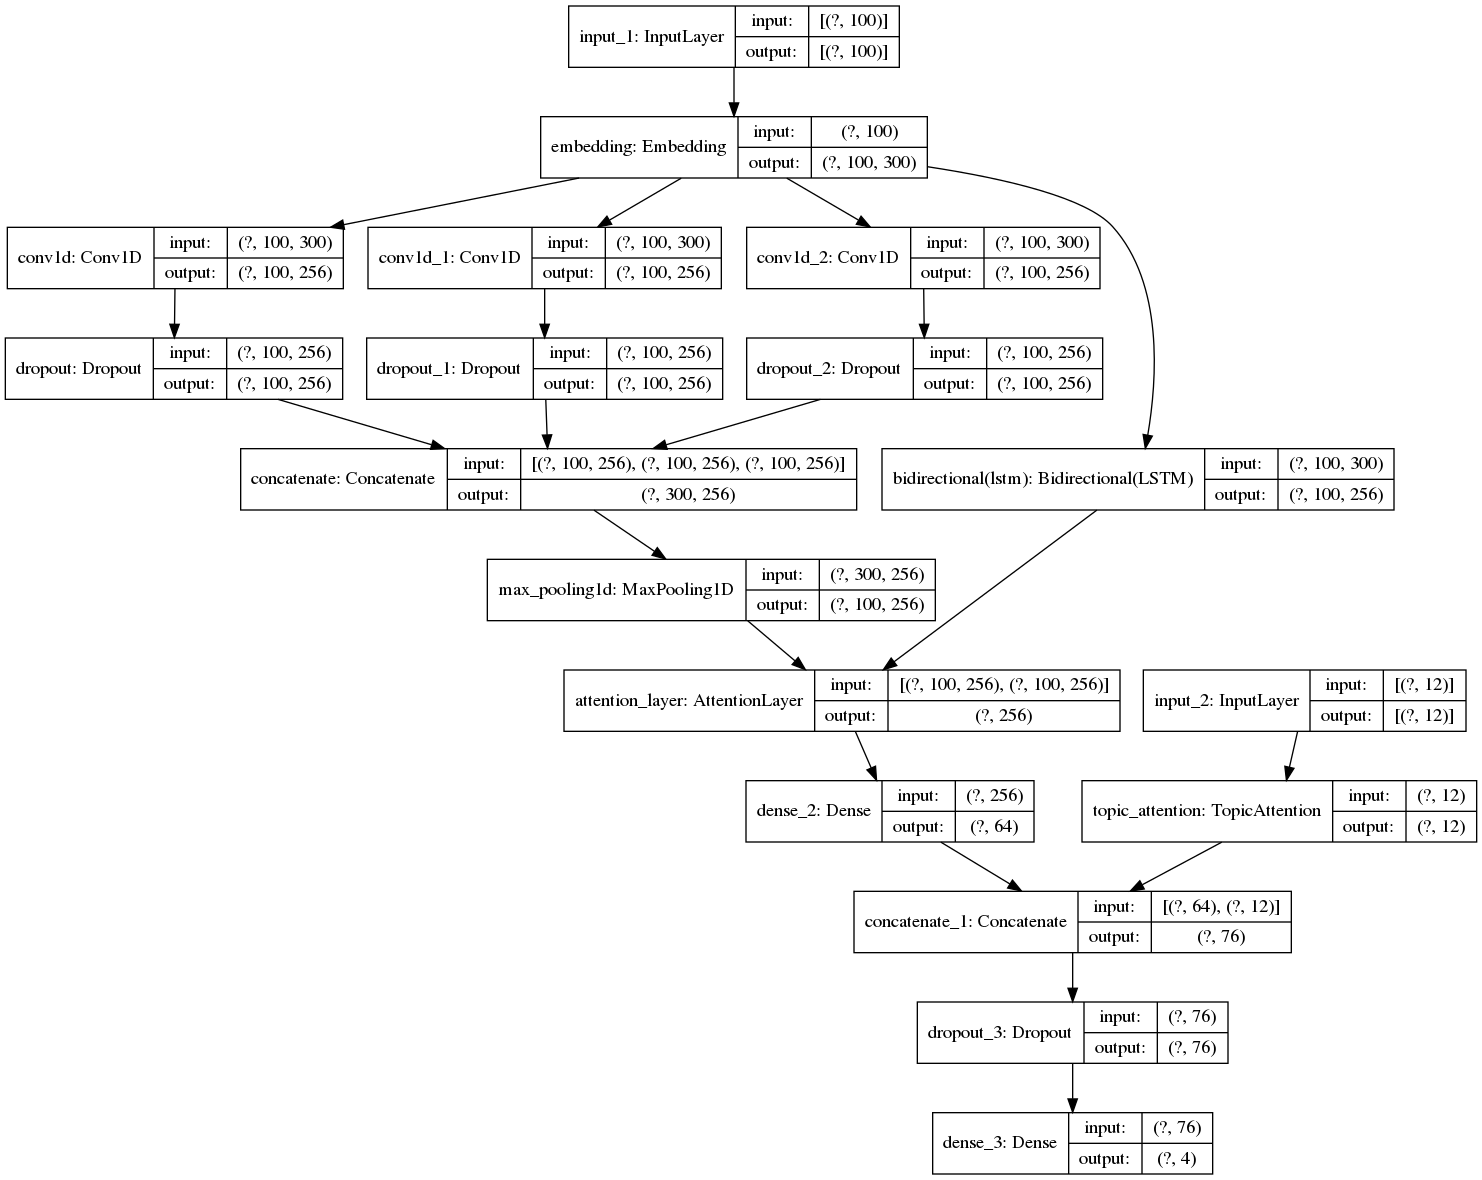

In [23]:
plot_model(classifier, show_shapes=True)

In [24]:
# ModelCheckPoint Callback:
checkpoint_filepath = "../models/embedding-LDA-attention/context-attention-multi-channel-embeddings-LDA-epoch-{epoch:02d}-val-acc-{val_acc:02f}.h5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_acc',
                                            mode='max',
                                            save_freq = 'epoch',
                                            save_best_only=True)

# Reduce Learning Rate on Plateau Callback:
reduce_lr_callback = ReduceLROnPlateau( monitor='val_loss', 
                                       factor=0.1, 
                                       patience=2, 
                                       min_lr=0.0005, 
                                       verbose=2)
#myCB = myCallbacks(metrics='acc', threshold=0.97)

In [25]:
history = classifier.fit([x_train_padded, X_train_LDA], 
                         y_train, 
                         epochs=15,
                         batch_size=128,
                         verbose=1,
                         validation_data=([x_val_padded, X_val_LDA], y_val),
                         callbacks=[model_checkpoint_callback, reduce_lr_callback])

Epoch 1/15
329/329 [==============================] - 347s 1s/step - loss: 0.4980 - acc: 0.8166 - val_loss: 0.3567 - val_acc: 0.8712 - lr: 0.0010
Epoch 2/15
329/329 [==============================] - 373s 1s/step - loss: 0.3575 - acc: 0.8718 - val_loss: 0.3404 - val_acc: 0.8759 - lr: 0.0010
Epoch 3/15
329/329 [==============================] - 384s 1s/step - loss: 0.3134 - acc: 0.8873 - val_loss: 0.3182 - val_acc: 0.8902 - lr: 0.0010
Epoch 4/15
329/329 [==============================] - 392s 1s/step - loss: 0.2820 - acc: 0.8986 - val_loss: 0.3377 - val_acc: 0.8775 - lr: 0.0010
Epoch 5/15
329/329 [==============================] - ETA: 0s - loss: 0.2454 - acc: 0.9118
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005.
329/329 [==============================] - 385s 1s/step - loss: 0.2454 - acc: 0.9118 - val_loss: 0.3243 - val_acc: 0.8892 - lr: 0.0010
Epoch 6/15
329/329 [==============================] - 398s 1s/step - loss: 0.1847 - acc: 0.9340 - val_loss: 0.3278 - val_acc:

In [56]:
history = classifier.fit([x_train_padded, X_train_LDA], 
                         y_train, 
                         epochs=15,
                         batch_size=128,
                         verbose=1,
                         validation_data=([x_val_padded, X_val_LDA], y_val),
                         callbacks=[model_checkpoint_callback, reduce_lr_callback])

Epoch 1/15
329/329 [==============================] - 894s 3s/step - loss: 0.4992 - acc: 0.8157 - val_loss: 0.3822 - val_acc: 0.8585 - lr: 0.0010
Epoch 2/15
329/329 [==============================] - 868s 3s/step - loss: 0.3615 - acc: 0.8703 - val_loss: 0.3355 - val_acc: 0.8767 - lr: 0.0010
Epoch 3/15
329/329 [==============================] - 870s 3s/step - loss: 0.3190 - acc: 0.8851 - val_loss: 0.3309 - val_acc: 0.8828 - lr: 0.0010
Epoch 4/15
329/329 [==============================] - 891s 3s/step - loss: 0.2818 - acc: 0.8984 - val_loss: 0.3183 - val_acc: 0.8873 - lr: 0.0010
Epoch 5/15
329/329 [==============================] - 876s 3s/step - loss: 0.2538 - acc: 0.9080 - val_loss: 0.3105 - val_acc: 0.8878 - lr: 0.0010
Epoch 6/15
329/329 [==============================] - 874s 3s/step - loss: 0.2152 - acc: 0.9229 - val_loss: 0.3187 - val_acc: 0.8857 - lr: 0.0010
Epoch 7/15
329/329 [==============================] - ETA: 0s - loss: 0.1867 - acc: 0.9320
Epoch 00007: ReduceLROnPlateau re

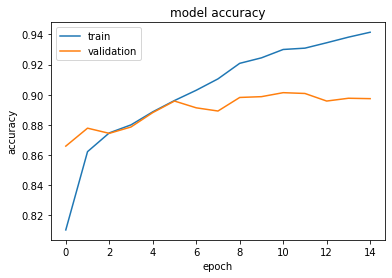

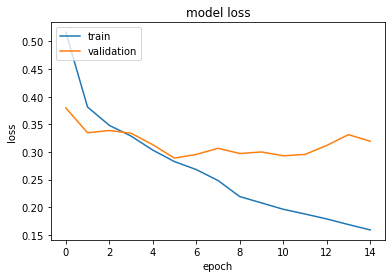

In [24]:
plot_curves(history)

In [25]:
classifier.load_weights("../models/embedding-LDA/new-multi-channel-embeddings-LDA-attention-epoch-11-val-acc-0.901323.h5")

In [26]:
results = np.argmax(classifier.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.9013227513227513

Precision:  [0.94186047 0.88583905 0.9430605  0.87676768]
Average Precision:  0.9118819229706281

Recall:  [0.77142857 0.94352159 0.89830508 0.89484536]
Average Recall:  0.8770251529208654

F1-Score:  [0.84816754 0.91377091 0.92013889 0.88571429]
Average F1-Score:  0.891947906910276


In [27]:
predictions =  np.argmax(classifier.predict([x_test_padded, X_test_LDA]), axis=-1)
len(predictions)

1788

In [28]:
original_labels = list(le.inverse_transform(predictions))
len(original_labels)

1788

In [29]:
df = pd.DataFrame(list(zip(test_data, original_labels)), columns=['text', 'predicted_label'])
df

,text,predicted_label
0,हे फॉर्मल एजुकेशन नॉन फॉर्मल एजुकेशन आणि इन फॉ...,com_tech
1,कम्युनिकेशन तेवढेच प्राचीन आहे जेवढा मनुष्यजन्म,com_tech
2,याबद्दल मी काही बोलण्यापूर्वी कोलॅजन मॉडेल कसे...,com_tech
3,बर्याच तज्ञांचा असा विश्वास आहे की मोबाईल उपकर...,com_tech
4,वजन कमी करण्याच्या समस्येसाठी लोक स्पार्क पीपल...,cse
...,...,...
1783,बायबलमध्ये मानवी भाषांच्या उत्पत्तीविषयी स्पष्...,com_tech
1784,आणि म्हणूनच ph हे pka म्हणून मोजले जाऊ शकते म्...,bioche
1785,उदाहरणार्थ आम्ही पूर्वी ज्या पद्धतीने चर्चा के...,com_tech
1786,हे धारण क्षमता वाढवते,phy


In [54]:
df.to_csv("../results/marathi-embedding-LDA-attention-predictions.tsv", sep='\t', index=False)

In [31]:
df.predicted_label.value_counts()

com_tech    1058
bioche       273
cse          233
phy          224
Name: predicted_label, dtype: int64

# BiLSTM before CNN

In [22]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)

# Embeddings to BiLSTM:
Lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(Embedding_layer1)

# Embeddings to CNN:
Conv1 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(Embedding_layer1)
Dropout1 = Dropout(0.3)(Conv1)
Conv2 = Conv1D(filters=256, kernel_size=4, activation='relu', padding='same')(Embedding_layer1)
Dropout2 = Dropout(0.3)(Conv2)
Conv3 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(Embedding_layer1)
Dropout3 = Dropout(0.3)(Conv3)
merged = concatenate([Dropout1, Dropout2, Dropout3], axis=1)
max_pool = MaxPooling1D(pool_size=3)(merged)

attention1 = AttentionLayer()([Lstm, max_pool])
Dense1 = Dense(64, activation='relu')(attention1)

# LDA Input:
Input2 = Input(shape=(input_len2, ))
attention2 = TopicAttention()(Input2)

merged = concatenate([Dense1, attention2])
Dropout_dense = Dropout(0.25)(merged)

outputs = Dense(4, activation='softmax')(Dropout_dense)

classifier1 = Model(inputs=[Input1, Input2], outputs=outputs)
classifier1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     16509000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 256)     230656      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 256)     307456      embedding[0][0]                  
______________________________________________________________________________________________

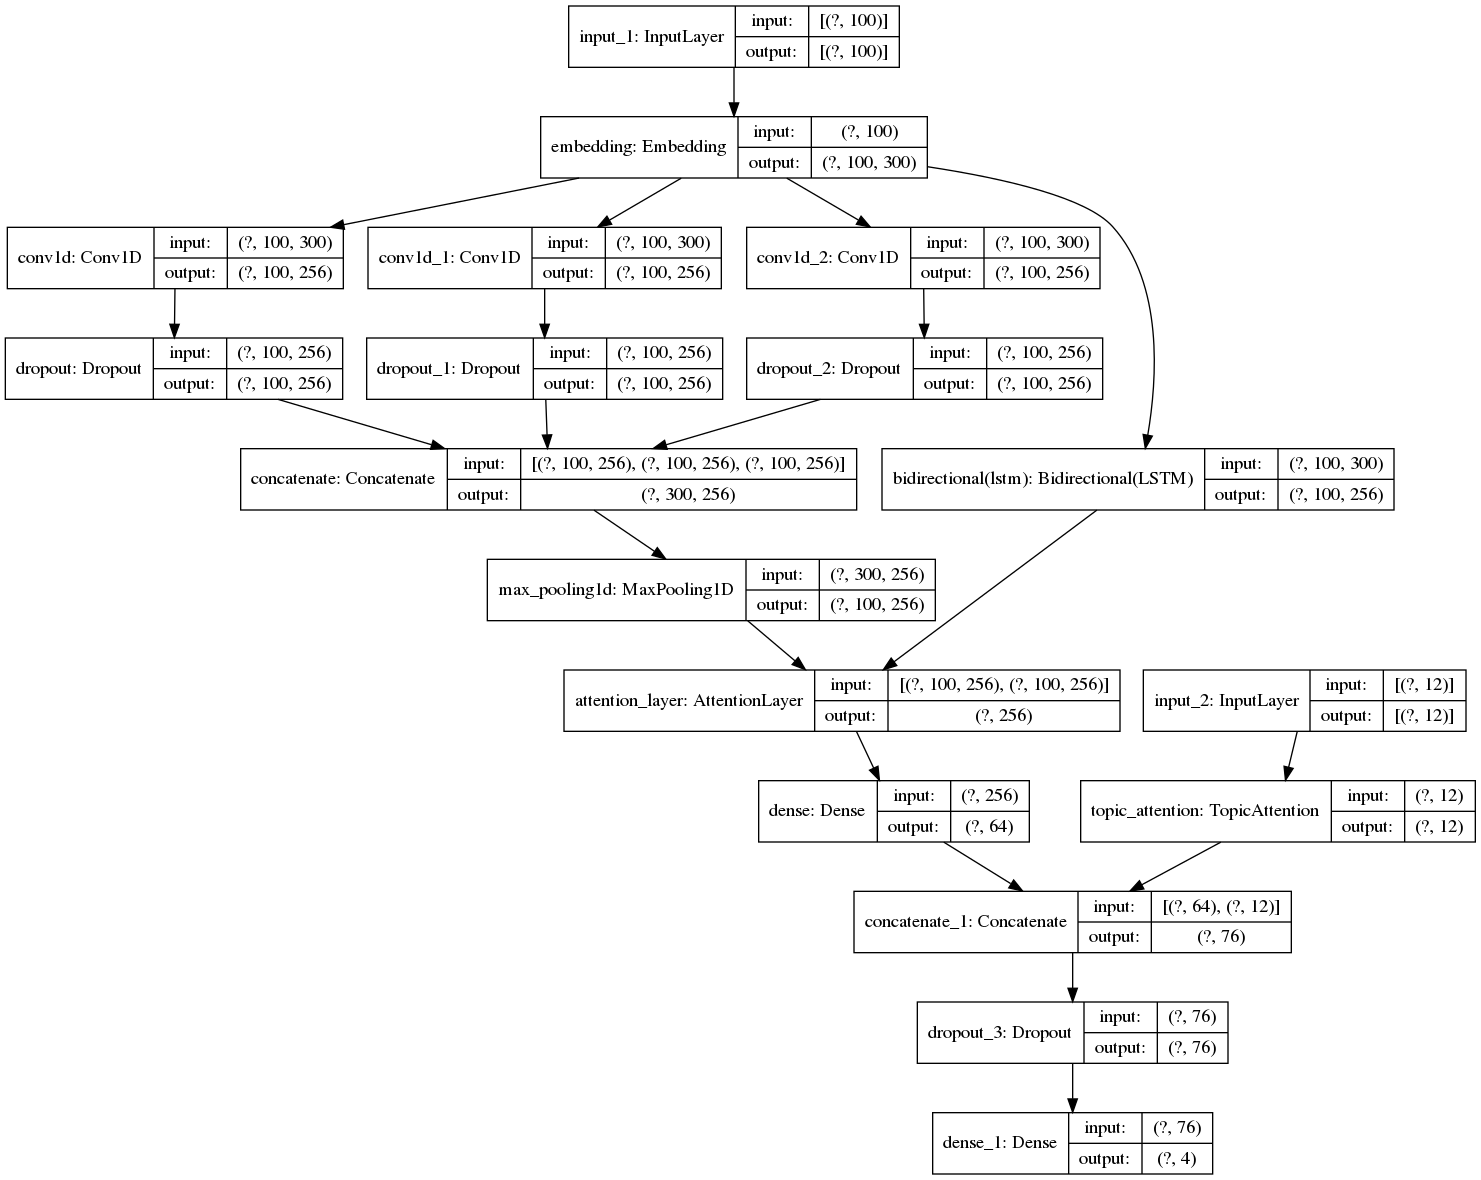

In [23]:
plot_model(classifier1, show_shapes=True)

In [24]:
# ModelCheckPoint Callback:
checkpoint_filepath1 = "../models/embedding-LDA-attention/preprocess-multi-channel-embeddings-before-CNN-epoch-{epoch:02d}-val-acc-{val_acc:02f}.h5"
model_checkpoint_callback1 = ModelCheckpoint(filepath=checkpoint_filepath1,
                                            save_weights_only=True,
                                            monitor='val_acc',
                                            mode='max',
                                            save_freq = 'epoch',
                                            save_best_only=True)

# Reduce Learning Rate on Plateau Callback:
reduce_lr_callback1 = ReduceLROnPlateau( monitor='val_loss', 
                                       factor=0.1, 
                                       patience=2, 
                                       min_lr=0.0005, 
                                       verbose=2)
#myCB = myCallbacks(metrics='acc', threshold=0.97)

In [25]:
history1 = classifier1.fit([x_train_padded, X_train_LDA], 
                           y_train, 
                           epochs=16,
                           batch_size=128,
                           verbose=1,
                           validation_data=([x_val_padded, X_val_LDA], y_val),
                           callbacks=[model_checkpoint_callback1, reduce_lr_callback1])

Epoch 1/16
329/329 [==============================] - 484s 1s/step - loss: 0.5143 - acc: 0.8111 - val_loss: 0.3699 - val_acc: 0.8632 - lr: 0.0010
Epoch 2/16
329/329 [==============================] - 444s 1s/step - loss: 0.3826 - acc: 0.8625 - val_loss: 0.3500 - val_acc: 0.8728 - lr: 0.0010
Epoch 3/16
329/329 [==============================] - 499s 2s/step - loss: 0.3552 - acc: 0.8719 - val_loss: 0.3480 - val_acc: 0.8714 - lr: 0.0010
Epoch 4/16
329/329 [==============================] - 494s 2s/step - loss: 0.3297 - acc: 0.8805 - val_loss: 0.3181 - val_acc: 0.8828 - lr: 0.0010
Epoch 5/16
329/329 [==============================] - 560s 2s/step - loss: 0.3083 - acc: 0.8876 - val_loss: 0.3095 - val_acc: 0.8844 - lr: 0.0010
Epoch 6/16
329/329 [==============================] - 512s 2s/step - loss: 0.2905 - acc: 0.8935 - val_loss: 0.3059 - val_acc: 0.8902 - lr: 0.0010
Epoch 7/16
329/329 [==============================] - 481s 1s/step - loss: 0.2680 - acc: 0.9026 - val_loss: 0.3031 - val_acc

KeyboardInterrupt: 

In [ ]:
plot_curves(history1)

In [ ]:
classifier1.load_weights("../models/embedding-LDA/multi-channel-embeddings-LDA-epoch-08-val-acc-0.896561.h5")

In [ ]:
results1 = np.argmax(classifier1.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))